In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [10]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [11]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed, 5)

In [14]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [12]:
len(data_te_vl[2])

6426

In [13]:
len(y_te_te)

6438

In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.028, identitity_weight_decay=0.96)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 1.2613 | val loss 0.7716 | acc 0.2126 | f1 0.3506 | prec 0.2126 | recall 1.0000 | roc auc 0.5113 | pr auc 0.2443 | elapsed 29.76s
train epoch 01/10 | batch 1704/1703 | loss 0.9676 | val loss 0.5094 | acc 0.8127 | f1 0.3319 | prec 0.6861 | recall 0.2189 | roc auc 0.6554 | pr auc 0.4655 | elapsed 59.67s
train epoch 02/10 | batch 1704/1703 | loss 0.6371 | val loss 0.4422 | acc 0.8200 | f1 0.5392 | prec 0.5913 | recall 0.4955 | roc auc 0.7742 | pr auc 0.6063 | elapsed 59.73s
train epoch 03/10 | batch 1704/1703 | loss 0.4653 | val loss 0.4504 | acc 0.8189 | f1 0.5861 | prec 0.5698 | recall 0.6034 | roc auc 0.8018 | pr auc 0.6595 | elapsed 56.81s
train epoch 04/10 | batch 1704/1703 | loss 0.3505 | val loss 0.4920 | acc 0.8058 | f1 0.5892 | prec 0.5353 | recall 0.6552 | roc auc 0.8154 | pr auc 0.6850 | elapsed 51.88s
train epoch 05/10 | batch 1704/1703 | loss 0.2750 |

In [62]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 0.9632 | val loss 1.1907 | acc 0.6416 | f1 0.4253 | prec 0.3189 | recall 0.6382 | roc auc 0.6971 | pr auc 0.4693 | elapsed 6.77s
train epoch 01/10 | batch 849/848 | loss 0.8406 | val loss 1.0350 | acc 0.6662 | f1 0.4482 | prec 0.3413 | recall 0.6524 | roc auc 0.7261 | pr auc 0.5039 | elapsed 13.14s
train epoch 02/10 | batch 849/848 | loss 0.6035 | val loss 0.9180 | acc 0.6892 | f1 0.4732 | prec 0.3652 | recall 0.6719 | roc auc 0.7525 | pr auc 0.5378 | elapsed 13.29s
train epoch 03/10 | batch 849/848 | loss 0.4370 | val loss 0.8338 | acc 0.7054 | f1 0.4893 | prec 0.3824 | recall 0.6794 | roc auc 0.7742 | pr auc 0.5689 | elapsed 12.53s
train epoch 04/10 | batch 849/848 | loss 0.3270 | val loss 0.7735 | acc 0.7193 | f1 0.5074 | prec 0.3992 | recall 0.6959 | roc auc 0.7916 | pr auc 0.5970 | elapsed 12.39s
train epoch 05/10 | batch 849/848 | loss 0.2559 | val loss 0.7292 | acc 0.7323 | f1 0.5235 | prec 0.4154 | recall 0.7079 | roc au

In [63]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

             mean       std     micro
acc      0.789656  0.058916  0.789997
prec     0.509491  0.111586  0.498560
recall   0.778148  0.070894  0.771917
f1       0.607752  0.083144  0.605831
auc_roc  0.863210  0.046083  0.862842
auc_pr   0.742090  0.087713  0.742739


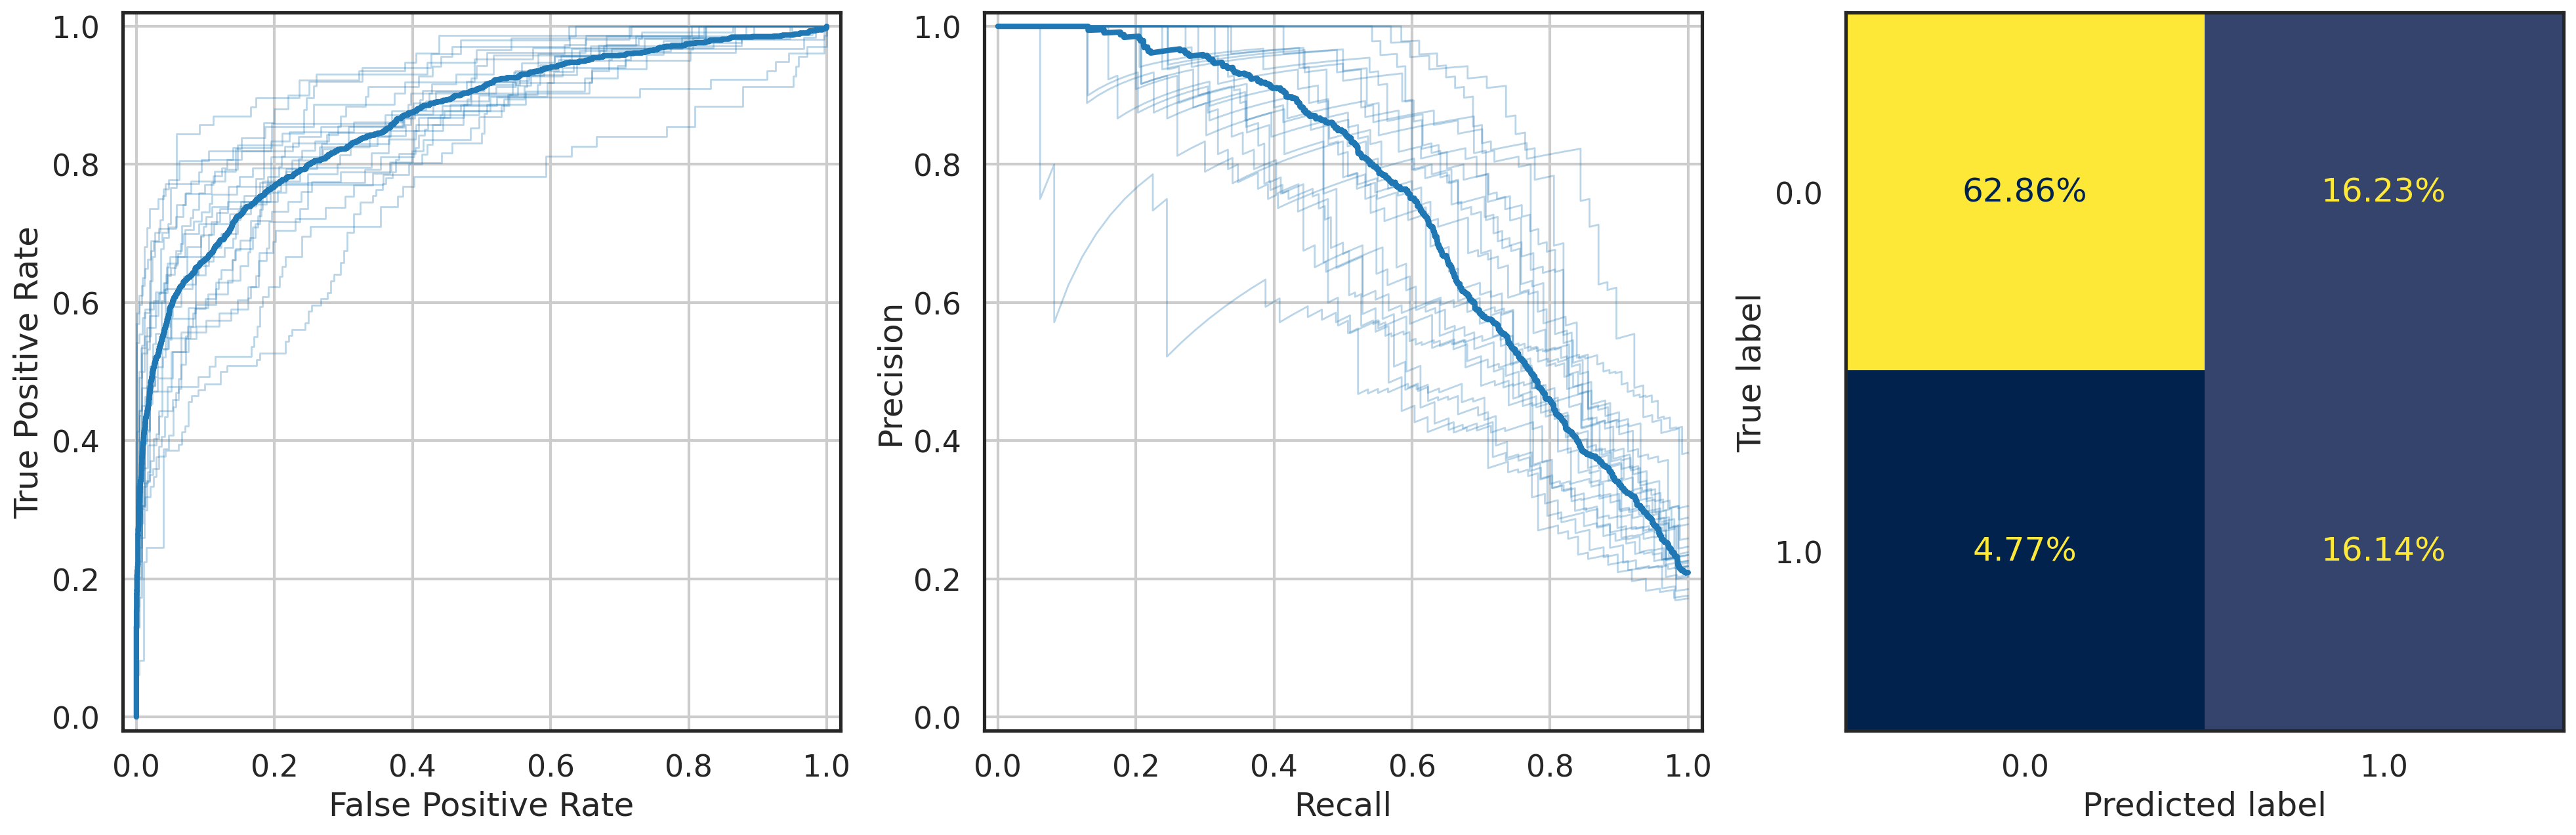

In [64]:
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))

In [10]:
import random

In [68]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([-0.2067,  0.1027, -0.0464,  0.0305, -0.1408,  0.0381, -0.2522,  0.0390,
        -0.1248,  0.1231], grad_fn=<SelectBackward0>)
tensor([ 0.1289, -0.0238,  0.0404, -0.1703,  0.1722, -0.1243, -0.0896, -0.0574,
        -0.0679,  0.0352], grad_fn=<AddBackward0>)
0.13394845824688673


In [75]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.3506,  0.2761,  0.0538, -0.4003,  0.4443, -0.0546,  0.1105,  0.1829,
        -0.2919, -0.1479], grad_fn=<SelectBackward0>)
tensor([ 0.3916,  0.2596,  0.0539, -0.3849,  0.4164, -0.0236,  0.1129,  0.1781,
        -0.2932, -0.1612], grad_fn=<AddBackward0>)
0.021657431951723993


In [56]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.1949,  0.1364, -0.0334,  0.0379, -0.0442, -0.0976, -0.0202, -0.0664,
        -0.0679, -0.1381], grad_fn=<SelectBackward0>)
tensor([-0.0180,  0.0055, -0.0015, -0.0177,  0.0163, -0.0873, -0.0305, -0.0294,
        -0.0271, -0.0258], grad_fn=<AddBackward0>)
0.08063862405717373


In [57]:
losses = []
for _ in range(1000):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.3506,  0.2761,  0.0538, -0.4003,  0.4443, -0.0546,  0.1105,  0.1829,
        -0.2919, -0.1479], grad_fn=<SelectBackward0>)
tensor([ 0.1854,  0.0551,  0.0352, -0.2326,  0.2693, -0.1105,  0.0161,  0.0253,
        -0.1524, -0.0288], grad_fn=<AddBackward0>)
0.14583707723766565


In [15]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.3506,  0.2761,  0.0538, -0.4003,  0.4443, -0.0546,  0.1105,  0.1829,
        -0.2919, -0.1479], grad_fn=<SelectBackward0>)


tensor([ 0.3505,  0.2755,  0.0541, -0.3994,  0.4441, -0.0549,  0.1110,  0.1830,
        -0.2917, -0.1477], grad_fn=<SqueezeBackward3>)
tensor(0.0003, grad_fn=<L1LossBackward0>)


In [16]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.1108, -0.2444,  0.0286,  0.6020, -0.0014,  0.1687,  0.9170,  0.0992,
        -0.0894,  0.3121], grad_fn=<SelectBackward0>)
tensor([-0.1110, -0.2448,  0.0281,  0.6024, -0.0017,  0.1692,  0.9176,  0.0989,
        -0.0893,  0.3126], grad_fn=<SqueezeBackward3>)
tensor(0.0004, grad_fn=<L1LossBackward0>)


In [58]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.3324,  0.1994,  0.0525, -0.3608,  0.3862, -0.0649,  0.0925,  0.1231,
        -0.2667, -0.1457], grad_fn=<AddBackward0>)
tensor([ 0.3278,  0.1935,  0.0625, -0.3614,  0.4018, -0.0602,  0.0958,  0.1375,
        -0.2344, -0.1451], grad_fn=<AddBackward0>)
0.01767979703983292


In [59]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.1926,  0.0507,  0.0463, -0.2243,  0.2579, -0.1287, -0.0245, -0.0770,
        -0.0689, -0.0243], grad_fn=<AddBackward0>)
tensor([ 0.1838,  0.0290,  0.0615, -0.2453,  0.2462, -0.1226, -0.0364, -0.0044,
        -0.1314, -0.0353], grad_fn=<AddBackward0>)
0.02304548512212932


In [60]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.0102, -0.0656,  0.0005,  0.3156,  0.0420, -0.2694, -0.0780, -0.1283,
         0.0247,  0.0912], grad_fn=<SelectBackward0>)
tensor([-0.0178, -0.0874,  0.0056,  0.1522, -0.0201, -0.1280, -0.0561, -0.0798,
         0.0495,  0.0811], grad_fn=<AddBackward0>)
0.06534908268228173


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9987921476364136


In [30]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999563694000244


In [23]:
T.round(T.matmul(trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100

tensor([[1., -0., 0., 0., -0., 0., -0., 0., -0., -0.],
        [-0., 1., 0., -0., -0., -0., 0., -0., 0., -0.],
        [-0., -0., 1., -0., -0., -0., -0., 0., 0., -0.],
        [-0., -0., -0., 1., -0., -0., -0., -0., -0., 0.],
        [-0., -0., 0., 0., 1., -0., -0., 0., -0., -0.],
        [0., 0., 0., -0., 0., 1., 0., 0., 0., -0.],
        [-0., -0., -0., 0., -0., -0., 1., 0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., 1., -0., 0.],
        [0., -0., 0., 0., -0., -0., 0., -0., 1., -0.],
        [0., 0., 0., 0., 0., -0., 0., 0., -0., 1.]], grad_fn=<DivBackward0>)